<a id=start></a>
# Parser for Apophis Testing

Includes toggle for plotting original or buffered data. <br>
Does not include any fixes for bad data

#### Shortcuts to Sections:
* [Setup](#start)
* [Load & Parse Data](#parsing)
* [Save Parsed Data to Frickle file](#saveFrickle)
* [Plotting Section](#plotting)

### In cell below:
> Enter data path, file name. <br>
> Choose 'original' or 'repeat'.<br>
> Specific plot parameters (e.g. time range) can be adjusted in the last cell.

In [1]:
# path = "../delamere_data/delamere_flight_data/" # Path to saved file on local machine
# file_name = "data_file_115k_usbmodem145101.txt"
# path = "kinetx_data/dallas/" # Path to saved file on local machine
# file_name = "Dallas1_FlightData_5-16-2021.txt"
# file_name = "Flight-data_file_230k_1-05_16_21.txt"

# path ="./"
# file_name = "20230515T171854Z_data_usbserial-FT611XTT3_230400_15.bin"
# path = "./data/"
# file_name = "20230614T193044Z_data_usbserial-FT611XTT3_230400_shield29-first-plasma-test-C_29.bin"
# path = "./data/apophisChamber/19June2023/"
# file_name = "20230619T164554Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-rollA_28.bin"
# file_name = "20230619T170046Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-pitchA_28.bin"
# file_name = "20230619T171535Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-rollB_28.bin"
# file_name = "20230619T172226Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-pitchB_28.bin"

# path = "./apep2_data/"
# # file_name = "04-08_Apep392_Swarm_FlightData_UDP_Bob33.bin"; T0_offset=313.89053
# file_name = "04-08_Apep393_Swarm_FlightData_UDP_Bob34.bin"
# # file_name = "04-08_Apep394_Swarm_FlightData_UDP_Bob35.bin"; T0_offset=750.16486

path = "./apep1_data/"
# file_name = "BOB28_36_386_launch_swarm_udpwrite_playback.bin" 
# file_name = "BOB30_36_387_launch_swarm_udpwrite_playback.bin"
file_name = "BOB31_36_388_launch_swarm_udpwrite.bin"

plottype = 'original' # Choose 'original' or 'repeat'

interruptOffset = 0 # Offset between interrupt timestamps and imu/sweep timestamps
# interruptOffset = -8.0062 # KiNET-X Mission's time offset between interrupt timestamps and imu/sweep timestamps
T0_offset = 0 # Right now ONLY affect the sweepSampleTime NOT sweepTime or imuTime
# T0_offset = 572.732
flag_applyT0=False

In [2]:
import sys
import os
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from bitstring import BitArray

## Custom Library
import parser_lib

%matplotlib notebook

dataFile = os.path.join(path, file_name)



<a id="parsing"></a>
### Load & Parse Data

In [3]:
# import importlib
# importlib.reload(parser_lib)
f = open(dataFile, 'rb')
rawData = f.read()

## Set parameters
buffered=True; dim=int(buffered)+1 # Whether 
# data scales:
# scale_dct = {'time': 1e-6, 'acc': 4./2**15, 'mag': 1./2**15, 'gyr': 2000./360/2**15, 'pip': 5./2**14} 
scale_dct = {'time': 1e-6, 'acc': 4.*9.8/2**15, 'mag': 1./2**15, 'gyr': 2000./360/2**15, 'pip': 5./2**14} 

# Sentinel strings: 
sentinels = ['0x2353','0x2349','0x2354','0x234A'] # 
# sentinels = ['##S','##I','##T','##J']
sentinel_size = 2#3
# Various sample

freq = 45 # approximate message frequency in Hz
num_samples = 28 # how many samples per pip per sweep message
num_swp_bytes = 4 + 1 + num_samples * 2 * 2 # 4 times bytes, 1 id byte, 2 bytes per sample per 2 pips
num_imu_bytes = 4 + (3 + 3 + 3 + 1) * 2 # 4 time bytes, xyz for agm each 2 bytes, 2 temp bytes
num_msg_bytes = (2*sentinel_size + num_swp_bytes + num_imu_bytes)*dim

bytesRaw = BitArray(rawData) # read bytes from standard input
ids_swp = list(bytesRaw.findall(sentinels[0], bytealigned=False))
ids_imu = list(bytesRaw.findall(sentinels[1], bytealigned=False))
if buffered:
    ids_swp_buf = list(bytesRaw.findall(sentinels[2], bytealigned=False))
    ids_imu_buf = list(bytesRaw.findall(sentinels[3], bytealigned=False))
else:
    ids_swp_buf = ids_swp
    ids_imu_buf = ids_imu

# num_data_swp = max(len(ids_swp),len(ids_swp_buf))*num_samples # sweep data is repeated per sweep sample
num_data_swp = max(len(ids_swp),len(ids_swp_buf))
num_data_imu = max(len(ids_imu),len(ids_imu_buf))

# initialize data arrays
sweepTime_arr = np.zeros([dim,num_data_swp],dtype='single')
payload_id = np.zeros([dim,num_data_swp],dtype='uint8')
pip_volts = np.zeros([dim,2,num_data_swp, num_samples],dtype='single')
pip_voltsLn = np.zeros([dim,2,num_data_swp*num_samples],dtype='single')
sweepTimeLn_arr = np.zeros([dim,num_data_swp*num_samples],dtype='single')
imuTime_arr = np.zeros([dim,num_data_imu],dtype='single')
acc_arr = np.zeros([dim,3,num_data_imu],dtype='single')
mag_arr = np.zeros([dim,3,num_data_imu],dtype='single')
gyr_arr = np.zeros([dim,3,num_data_imu],dtype='single')

# imuTime_arr[0], acc_arr[0], mag_arr[0], gyr_arr[0] = parse_swp(ids_swp,False, dim=1)
# sweepTime_arr[0], payload_id, pip_volts[0] = parse_imu(ids_imu,False, dim=1)
print('Start Parsing')
imuTime_arr[0], acc_arr[0], mag_arr[0], gyr_arr[0] = parser_lib.parse_imu(bytesRaw, ids_imu, is_buffer_data=False, sentinels=sentinels, num_imu_bytes=num_imu_bytes, num_dat_imu=num_data_imu, scale_dct=scale_dct)
print('Finished IMU Parse')
sweepTime_arr[0], payload_id[0], pip_volts[0], sweepTimeLn_arr[0], pip_voltsLn[0] = parser_lib.parse_swp(bytesRaw, ids_swp, is_buffer_data=False, sentinels=sentinels, num_swp_bytes=num_swp_bytes, num_dat_swp=num_data_swp, num_samples=num_samples, freq=freq, scale_dct=scale_dct)
print('Finished Sweep Parse')

if buffered:
    imuTime_arr[1], acc_arr[1], mag_arr[1], gyr_arr[1] = parser_lib.parse_imu(bytesRaw, ids_imu_buf, is_buffer_data=True, sentinels=sentinels, num_imu_bytes=num_imu_bytes, num_dat_imu=num_data_imu, scale_dct=scale_dct)
    print('Finished Buffered IMU Parse')
    sweepTime_arr[1], payload_id[1], pip_volts[1], sweepTimeLn_arr[1], pip_voltsLn[1] = parser_lib.parse_swp(bytesRaw, ids_swp_buf, is_buffer_data=True, sentinels=sentinels, num_swp_bytes=num_swp_bytes, num_dat_swp=num_data_swp, num_samples=num_samples, freq=freq, scale_dct=scale_dct)
    print('Finished Buffered Sweep Parse')     
print('Done Parsing')

# measured values
imu_cad = np.diff(imuTime_arr,append=np.nan)*1e3 # imu cadence in ms
imu_cad_avg = np.nanmedian(imu_cad)
# imu_freq = 1e3/imu_cad_avg # imu frequency in Hz
# pip0_std = np.nanstd(pip_voltsLn[0,0,:-100])*1e3 # pip 0 standard deviation
# pip1_std = np.nanstd(pip_voltsLn[0,1,:-100])*1e3 # pip 1 standard deviation

f.close()

Start Parsing
Finished IMU Parse
Finished Sweep Parse
Finished Buffered IMU Parse
Finished Buffered Sweep Parse
Done Parsing


In [21]:
imuTime_arr

array([[702.2572 , 702.3238 , 703.16736, ...,   0.     ,   0.     ,
          0.     ],
       [692.2228 , 693.15515, 693.17737, ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)

In [4]:
# print(np.all(np.where(sweepTime_arr[0]!=0)[0] == np.where(sweepTime_arr[1]!=0)[0]))
from scipy import stats
shieldID = stats.mode(payload_id[np.where(payload_id != 0)])[0][0]
# #(payload_id[np.where(payload_id != 0)])
print(shieldID)

31


In [5]:
# Changes screen voltage to nA
highV2I = 1.0/(320.0E-3)
lowV2I = 1.0/(40.0E-3)
pip0V2I = lowV2I; pip1V2I = highV2I

pip_nA = np.zeros(pip_volts.shape, dtype='single')

pip_nA[0,1] = (pip_volts[0,0]-1)*pip0V2I
pip_nA[0,1] = (pip_volts[0,1]-1)*pip1V2I
pip_nA[1,0] = (pip_volts[1,0]-1)*pip0V2I
pip_nA[1,1] = (pip_volts[1,1]-1)*pip1V2I


In [6]:
## Optional (?) Filtering
# max_time = 630+T0_offset

# find invalid timestamps
# inv_ids_swp = (sweepTime_arr==0) | (sweepTime_arr>max_time)
# inv_ids_imu = (imuTime_arr==0) | (imuTime_arr>max_time)
inv_ids_swp = (sweepTime_arr==0) #| (sweepTime_arr>max_time)
inv_ids_imu = (imuTime_arr==0) #| (imuTime_arr>max_time)

# # remove invalid timestamps
# sweepTime_arr[inv_ids_swp] = np.nan
# imuTime_arr[inv_ids_imu] = np.nan
# # # # payload_id[inv_ids_swp] = np.nan
# # # # inv_ids_swp
# # # # sweepTime_arr[inv_ids_swp] 
# # print(inv_ids_swp)
# # print(inv_ids_imu)

In [7]:
## Change Times so Referenced to T0 (launch) 
if not flag_applyT0: 
    imuTime_arr = imuTime_arr-T0_offset
    sweepTime_arr = sweepTime_arr-T0_offset
    sweepTimeLn_arr = sweepTimeLn_arr-T0_offset
    flag_applyT0=True
    
##[DEBUG Only]: Revert times back to (raw) values from bin file
# imuTime_arr=imuTime_arr+T0_offset
# sweepTime_arr = sweepTime_arr+T0_offset
# sweepTimeLn_arr = sweepTimeLn_arr+T0_offset
# flag_applyT0=False

In [8]:
# # remove invalid timestamps
sweepTime_arr[inv_ids_swp] = np.nan
imuTime_arr[inv_ids_imu] = np.nan
badLocs = [np.where(inv_ids_imu[0])[0], np.where(inv_ids_imu[1])[0]]
badLocs = [np.where(inv_ids_swp[0])[0], np.where(inv_ids_swp[1])[0]]
# print(badLocs)
print((len(badLocs[0]), len(badLocs[1])))

(522, 690)


In [10]:
goodLocs = [np.where(np.logical_not(inv_ids_imu[0]))[0], np.where(np.logical_not(inv_ids_imu[1]))[0]]
goodLocs = [np.where(np.logical_not(inv_ids_swp[0]))[0], np.where(np.logical_not(inv_ids_swp[1]))[0]]
print(goodLocs)
print((len(goodLocs[0]), len(goodLocs[1])))

[array([    0,     1,     2, ..., 27113, 27114, 27115]), array([    0,     1,     2, ..., 26945, 26946, 26947])]
(27116, 26948)


<a id="saveFrickle"></a>
### Save Parsed Data to a Frickle file

In [ ]:
filterData = False

# ## Shield 33
# filterData = True
# tbnds = np.array([0, 1000])-T0_offset
# badIMU = [50, 1722, 1884, 1946, 1971, 2137, 2198, 2201, 2217, 2235, 2260, 2263, 2265, 2277, 2280, 2283, 2302, 2310, 2311, 2312, 2317, 2318, 2714, 5565, 7393, 7844, 8536, 8748, 8769, 12154, 13340, 13794, 18068]
# badSweep = [1448, 1545, 1748, 1763, 1805, 2014, 2030, 2055, 2066, 2091, 2133, 2189, 2210, 2260, 2303, 2304, 2305, 2311, 2315, 2385, 2637, 2716, 3058, 8038, 9206, 23267]
# badIMURpt = [1645, 1688, 1778, 1856, 1887, 2096, 2100, 2126, 2166, 2246, 2252, 2260, 2297, 2301, 2305, 2306, 2713, 2715, 2968, 3186, 4628, 6677, 8518, 16797, 21034, 22034, 24561, 26771]
# badSweepRpt = [1710, 2077, 2097, 2163, 2164, 2167, 2209, 2213, 2227, 2249, 2260, 2326, 2330, 2332, 2333, 2334, 2597, 2736, 2737, 3071, 5893, 6267, 24700, 24712, 25151, 25551, 26005, 27344]

# ## Shield 34
# filterData = True
# tbnds = np.array([0, 1280])-T0_offset
# badIMU = [2240, 2636, 3301, 3619, 3795, 5626, 6372, 7142, 7302, 7632, 8190,9061, 9685, 10495, 10743, 10879, 11330, 13321, 14044, 14273, 14720, 14724, 16068, 16241, 17353, 17366, 17759, 17804, 19514, 20190, 20540, 21035, 22330, 22566, 22921, 23140, 23591, 23865, 24193, 24248, 24604, 24833, 24855, 24899, 24900]
# badSweep = [133, 499, 3975, 4548, 4812, 4905, 5420, 5753, 7268, 12913, 13728, 14180, 14830, 17352, 17837, 18515, 18976, 19426, 21832, 24144, 24312, 24808, 24870]
# badIMURpt=[0, 1, 634, 5985, 7041, 7128, 7174, 7915, 8943, 10384, 10780, 11138, 11334, 11625, 12291, 12562, 13093, 13902, 14941, 16317, 17397, 18389, 18832, 21169, 21341, 21419, 21957, 23353, 23355, 23357, 23359, 23445, 23805, 23807, 23809, 24031, 24320, 24683, 24887, 24888, 24889]
# badSweepRpt=[1749, 5642, 5643, 7297, 7741, 8055, 8193, 11195, 11742, 12143, 12763, 12967, 13417, 13755, 18034, 18363, 18484, 19681, 21560, 22014, 22498, 23294, 24239, 24488, 24829, 24877, 24878, 24879, 24880]

# ## Shield 35
# filterData = True
# tbnds = np.array([0, 1400])-T0_offset
# badIMU = [0, 1, 3, 4, 6, 8, 10, 13, 37, 1348, 1771, 1833, 2095, 2433, 2756, 2759, 3119, 3136, 3948, 4150, 4599, 4678, 5490, 7526, 8206, 9474, 10202, 10385, 10421, 12307, 14661, 15113, 15549, 16002, 16032, 16485, 20257, 23334, 23780, 24246, 24821, 27995, 27996]
# badSweep = [0, 1, 2, 3, 4, 2078, 2149, 2336, 2344, 3490, 3946, 5787, 7630, 7670, 8483, 8965, 9369, 15723, 22426, 22868, 23136, 27446]
# badIMURpt = [0, 1, 2, 3, 4, 1710, 1718, 2139, 2387, 2525, 3073, 3314, 3461, 4190, 5852, 5932, 6368, 6841, 8304, 9734, 10399, 10647, 11098, 14966, 15403, 18946, 21822, 21824, 21826, 22266, 22268, 22270, 22338, 22783, 24463, 24656]
# badSweepRpt = [0, 1, 2, 3, 7, 13, 1869, 2189, 2234, 2262, 2322, 2388, 2646, 2982, 3692, 5342, 5609, 6239, 6631, 6684, 9093, 9540, 11440, 11704, 11892, 12157, 12555, 16925, 25566, 26017, 27857]

if filterData:
    imuLocs = np.where(np.logical_and(tbnds[0]<=imuTime, imuTime <= tbnds[1]))[0]
    sweepLocs = np.where(np.logical_and(tbnds[0]<=sweepTime, sweepTime <= tbnds[1]))[0]
    imuRptLocs = np.where(np.logical_and(tbnds[0]<=imuTimeRpt, imuTimeRpt <= tbnds[1]))[0]
    sweepRptLocs = np.where(np.logical_and(tbnds[0]<=sweepTimeRpt, sweepTimeRpt<= tbnds[1]))[0]

    imuLocs = np.delete(imuLocs, badIMU)
    sweepLocs = np.delete(sweepLocs, badSweep)
    imuRptLocs = np.delete(imuRptLocs, badIMURpt)
    sweepRptLocs = np.delete(sweepRptLocs, badSweepRpt)


In [74]:
# # Make/Save Frickle File as hdf5 file
# import h5py 
# import os
# frickle_path = '../rocket_analysis/Data/frickled_flightData/apep2/'
# tref_type='Reg'; flightData=False
# fklfname = os.path.join(frickle_path, "%sTime_ParsedData_Frickle-%s.hdf5" % (tref_type.capitalize(), file_name.partition(".")[0]))
# with h5py.File(fklfname, "w") as h5dct:
#     h5dct['parent_file'] = dataFile; #h5dct['DeltInx']=DeltInx
#     h5dct['shieldID']=shieldID;
#     h5dct['buff_data']=True
# #     dct['pipVoffset']
#     dct = h5dct.create_group('Original')
#     dct['imuTime']=imuTime; dct['temp']=temp; dct['ax']=ax; dct['ay']=ay; dct['az']=az
#     dct['gx']=gx; dct['gy']=gy; dct['gz']=gz; dct['mx']=mx; dct['my']=my; dct['mz']=mz
#     dct['sweepTime']=sweepTime; dct['sweepTimeLn']=sweepSampleTime; dct['sweepSize']=sweepSize; dct['sweepStepDt']=sweepStepDt
#     dct['pip0nA']=pip0nA; dct['pip1nA']=pip1nA; dct['pip0VLn']=pip0L; dct['pip1VLn']=pip1L
#     dct['pip0V2I']=pip0V2I; dct['pip1V2I']=pip1V2I
#     if filterData: dct['goodIMU_idxs'] = imuLocs; dct['goodSweep_idxs'] = sweepLocs
    
#     dctRpt = h5dct.create_group('Repeat')
#     dctRpt['imuTime']=imuTimeRpt; dctRpt['temp']=tempRpt; dctRpt['ax']=axRpt; dctRpt['ay']=ayRpt; dctRpt['az']=azRpt
#     dctRpt['gx']=gxRpt; dctRpt['gy']=gyRpt; dctRpt['gz']=gzRpt; dctRpt['mx']=mxRpt; dctRpt['my']=myRpt; dctRpt['mz']=mzRpt
#     dctRpt['sweepTime']=sweepTimeRpt; dctRpt['sweepTimeLn']=sweepSampleTimeRpt; dctRpt['sweepSize']=sweepSize; dctRpt['sweepStepDt']=sweepStepDt
#     dctRpt['pip0nA']=pip0RptnA; dctRpt['pip1nA']=pip1RptnA; dctRpt['pip0VLn']=pip0RptL; dctRpt['pip1VLn']=pip1RptL
#     dctRpt['pip0V2I']=pip0V2I; dctRpt['pip1V2I']=pip1V2I
#     if filterData: dctRpt['goodIMU_idxs'] = imuRptLocs; dctRpt['goodSweep_idxs'] = sweepRptLocs    
#     if flightData: h5dct['shield_T0'] = T0_dct[shieldID]
#     else: h5dct['shield_T0'] = 0
#     if tref_type.capitalize=='Flight': h5dct['applied_T0'] = True
#     else: h5dct['applied_T0'] = False
# del fklfname, h5dct

In [6]:
temp

array([   0,    0, 8960, ...,    0,    0,    0], dtype=int16)

<a id="plotting"></a> 
## Plotting Section

In [8]:
# ## Trim Data (If Already Determined bad locations and time bounds)
# filter_dct = dict()
# filter_dct[33]={'tbnds': np.array([0, 1000])-T0_offset, 'original': dict(), 'repeat': dict()}
# filter_dct[33]['original']['badIMU'] = [50, 1722, 1884, 1946, 1971, 2137, 2198, 2201, 2217, 2235, 2260, 2263, 2265, 2277, 2280, 2283, 2302, 2310, 2311, 2312, 2317, 2318, 2714, 5565, 7393, 7844, 8536, 8748, 8769, 12154, 13340, 13794, 18068]
# filter_dct[33]['original']['badSweep'] = [1448, 1545, 1748, 1763, 1805, 2014, 2030, 2055, 2066, 2091, 2133, 2189, 2210, 2260, 2303, 2304, 2305, 2311, 2315, 2385, 2637, 2716, 3058, 8038, 9206, 23267]
# filter_dct[33]['repeat']['badIMU'] = [1645, 1688, 1778, 1856, 1887, 2096, 2100, 2126, 2166, 2246, 2252, 2260, 2297, 2301, 2305, 2306, 2713, 2715, 2968, 3186, 4628, 6677, 8518, 16797, 21034, 22034, 24561, 26771]
# filter_dct[33]['repeat']['badSweep'] = [1710, 2077, 2097, 2163, 2164, 2167, 2209, 2213, 2227, 2249, 2260, 2326, 2330, 2332, 2333, 2334, 2597, 2736, 2737, 3071, 5893, 6267, 24700, 24712, 25151, 25551, 26005, 27344]
# filter_dct[34]={'tbnds': np.array([0, 1280])-T0_offset, 'original': dict(), 'repeat': dict()}
# filter_dct[34]['original']['badIMU'] = [2240, 2636, 3301, 3619, 3795, 5626, 6372, 7142, 7302, 7632, 8190,9061, 9685, 10495, 10743, 10879, 11330, 13321, 14044, 14273, 14720, 14724, 16068, 16241, 17353, 17366, 17759, 17804, 19514, 20190, 20540, 21035, 22330, 22566, 22921, 23140, 23591, 23865, 24193, 24248, 24604, 24833, 24855, 24899, 24900]
# filter_dct[34]['original']['badSweep'] = [133, 499, 3975, 4548, 4812, 4905, 5420, 5753, 7268, 12913, 13728, 14180, 14830, 17352, 17837, 18515, 18976, 19426, 21832, 24144, 24312, 24808, 24870]
# filter_dct[34]['repeat']['badIMU'] = [0, 1, 634, 5985, 7041, 7128, 7174, 7915, 8943, 10384, 10780, 11138, 11334, 11625, 12291, 12562, 13093, 13902, 14941, 16317, 17397, 18389, 18832, 21169, 21341, 21419, 21957, 23353, 23355, 23357, 23359, 23445, 23805, 23807, 23809, 24031, 24320, 24683, 24887, 24888, 24889]
# filter_dct[34]['repeat']['badSweep'] = [1749, 5642, 5643, 7297, 7741, 8055, 8193, 11195, 11742, 12143, 12763, 12967, 13417, 13755, 18034, 18363, 18484, 19681, 21560, 22014, 22498, 23294, 24239, 24488, 24829, 24877, 24878, 24879, 24880]
# filter_dct[35]={'tbnds': np.array([0, 1400])-T0_offset, 'original': dict(), 'repeat': dict()}
# filter_dct[35]['original']['badIMU'] = [0, 1, 3, 4, 6, 8, 10, 13, 37, 1348, 1771, 1833, 2095, 2433, 2756, 2759, 3119, 3136, 3948, 4150, 4599, 4678, 5490, 7526, 8206, 9474, 10202, 10385, 10421, 12307, 14661, 15113, 15549, 16002, 16032, 16485, 20257, 23334, 23780, 24246, 24821, 27995, 27996]
# filter_dct[35]['original']['badSweep'] = [0, 1, 2, 3, 4, 2078, 2149, 2336, 2344, 3490, 3946, 5787, 7630, 7670, 8483, 8965, 9369, 15723, 22426, 22868, 23136, 27446]
# filter_dct[35]['repeat']['badIMU'] = [0, 1, 2, 3, 4, 1710, 1718, 2139, 2387, 2525, 3073, 3314, 3461, 4190, 5852, 5932, 6368, 6841, 8304, 9734, 10399, 10647, 11098, 14966, 15403, 18946, 21822, 21824, 21826, 22266, 22268, 22270, 22338, 22783, 24463, 24656]
# filter_dct[35]['repeat']['badSweep'] = [0, 1, 2, 3, 7, 13, 1869, 2189, 2234, 2262, 2322, 2388, 2646, 2982, 3692, 5342, 5609, 6239, 6631, 6684, 9093, 9540, 11440, 11704, 11892, 12157, 12555, 16925, 25566, 26017, 27857]

# shield_id = 35
# if ableToTrim and np.isin(shield_id, list(filter_dct.keys())): 
#     imuLocs = np.where(np.logical_and(filter_dct[shield_id]['tbnds'][0]<=imuPlot, imuPlot <= filter_dct[shield_id]['tbnds'][1]))[0]
#     sweepLocs = np.where(np.logical_and(filter_dct[shield_id]['tbnds'][0]<=sweepPlot, sweepPlot <= filter_dct[shield_id]['tbnds'][1]))[0]
#     imuLocs = np.delete(imuLocs, filter_dct[shield_id][plottype]['badIMU'])
#     sweepLocs = np.delete(sweepLocs, filter_dct[shield_id][plottype]['badSweep'])

#     imuPlot = imuPlot[imuLocs]
#     axPlot = axPlot[imuLocs]
#     ayPlot = ayPlot[imuLocs]
#     azPlot = azPlot[imuLocs]
#     gxPlot = gxPlot[imuLocs]
#     gyPlot = gyPlot[imuLocs]
#     gzPlot = gzPlot[imuLocs]
#     mxPlot = mxPlot[imuLocs]
#     myPlot = myPlot[imuLocs]
#     mzPlot = mzPlot[imuLocs]
#     sweepPlot = sweepPlot[sweepLocs] #sweepPlot = sweepTime.tolist()
#     pip0Plot = pip0Plot[sweepLocs]
#     pip1Plot = pip1Plot[sweepLocs]
#     if plottype=='original': 
#         pip0LPlot = pip0.copy()[sweepLocs].flatten()
#         pip1LPlot = pip1.copy()[sweepLocs].flatten()
#     else:
#         pip0LPlot = pip0Rpt.copy()[sweepLocs].flatten()
#         pip1LPlot = pip1Rpt.copy()[sweepLocs].flatten()

# sweepTimeLPlot = []
# for t in sweepPlot:
#     for n in range(0, sweepSize):
#         sweepTimeLPlot.append(t+sweepStepDt*n)
# sweepTimeLPlot = np.array(sweepTimeLPlot)
# sweepTimeLPlot = sweepTimeLPlot - T0_offset

# magfullPlot = np.sqrt(mxPlot**2+myPlot**2+mzPlot**2)
# if 0<len(interruptArray): interruptValue = True
# else: interruptValue=False

# ableToTrim = False

In [7]:
print(imuTime_arr[0])
print(imuTime_arr[1])

[704.38837 704.4106  704.4328  ...   0.        0.        0.     ]
[694.354   694.37616 694.3984  ...   0.        0.        0.     ]


In [8]:
## Select Data to Plot 
plottype='repeat'
interruptValue=False
# if 0<len(interruptArray): interruptValue = True
# else: interruptValue=False

chInx = int(plottype=='repeat')

## Modify PIP Lineplots' and colorplots' x-axis limits and set PIP colorplots' colorbar limits
xlims=None #; xlims2=None
# # xlims = [460, 600]
# # xlims2 = [460, 600]
# xlims = [700, 745]
# xlims = [300, 390]
# xlims = [740, 830]
# xlims = [0, 1280]
# xlims = np.array([0, 1400])
# xlims = [sweepPlot[0]-5, sweepPlot[-1]+5]
# xlims = [sweepTime_arr[chInx,0]-5, sweepTime_arr[chInx, -1]+5]

ylims_dct = dict()
ylims_dct['pip0Ln']=[0, 5]; ylims_dct['pip1Ln']=[0, 5]
# ylims_dct={'mag': [-1,1]}
# ylims_dct['mag']=[-.25, .25]

cplt_kwargs={'pip0': {}, 'pip1':{}}
cplt_kwargs={'pip0': {'vmin':0, 'vmax':.5}, 'pip1': {'vmin':0, 'vmax':5}}
# # cplt_kwargs={'pip0': {'vmin':0, 'vmax':5}, 'pip1':{'vmin':1, 'vmax':8}}
# cplt_kwargs={'pip0': {'vmin':-2, 'vmax':10}, 'pip1':{'vmin':-2, 'vmax':10}}
# # cplt_kwargs={'pip0': {'vmin':-25, 'vmax':55}, 'pip1':{'vmin':-2, 'vmax':5.5}}
# cplt_kwargs={'pip0': {'vmin':0, 'vmax':20}, 'pip1':{'vmin':0, 'vmax':5.5}}
# # cplt_kwargs={'pip0': {'vmin':0, 'vmax':20}, 'pip1':{'vmin':0, 'vmax':20}}

alwaysPrintInterrupt=False

# print(np.all(np.where(sweepTime_arr[0]!=0)[0] == np.where(sweepTime_arr[1]!=0)[0]))

<IPython.core.display.Javascript object>


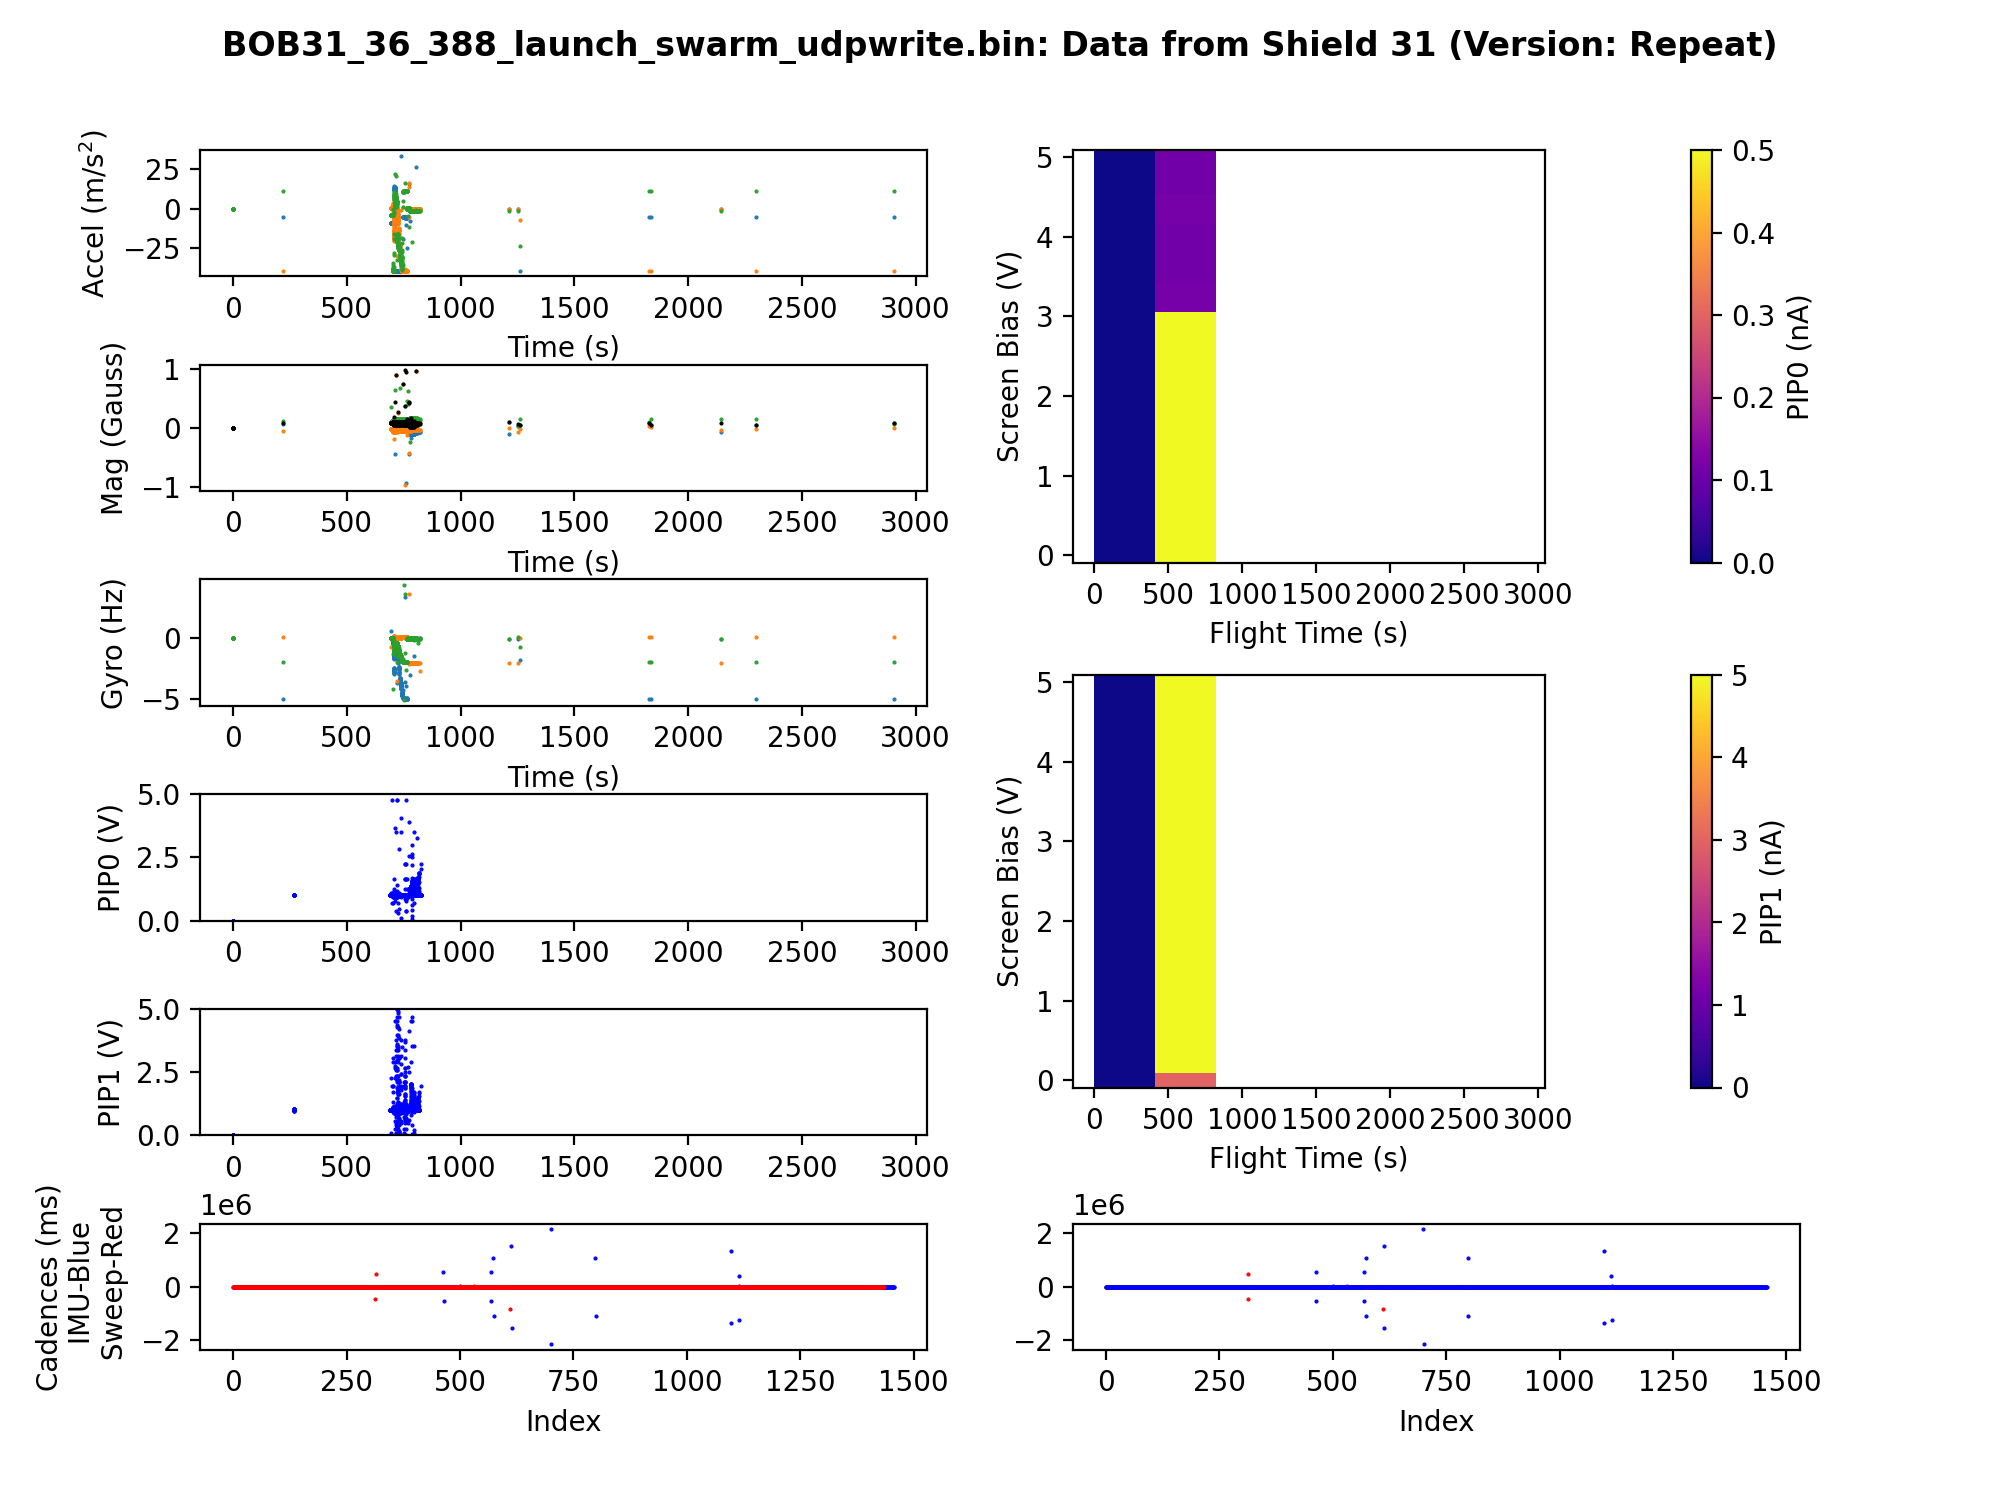

1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done


<ipython-input-9-5957aac6ea4e>:108: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(sweepTime_arr[chInx, goodLocs], sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
<ipython-input-9-5957aac6ea4e>:117: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(sweepTime_arr[chInx, goodLocs], sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])


In [9]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
# import scipy.signal as sig
# from scipy.interpolate import interp1d
# from scipy.io import savemat, loadmat
from __future__ import division

dots = True

gs_left = plt.GridSpec(6, 2,  hspace=0.7)

# Set up dots or not more cleanly
line_style = '-'
if dots:
    line_style = '.'

markersize = 1
if plt.fignum_exists(1): plt.close(1)
fig = plt.figure(1, figsize=(10, 7.5))

# Accel
ax1 = fig.add_subplot(gs_left[0,0])
plt.plot(imuTime_arr[chInx], acc_arr[chInx,0], line_style, markersize=markersize) 
plt.plot(imuTime_arr[chInx], acc_arr[chInx,1], line_style, markersize=markersize)  
plt.plot(imuTime_arr[chInx], acc_arr[chInx,2], line_style, markersize=markersize) 
plt.ylabel("Accel (m/s$^2$)")
#plt.ylim([-2, 2])
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("1 Done")

# Mag
fig.add_subplot(gs_left[1,0],sharex=ax1)
plt.plot(imuTime_arr[chInx], mag_arr[chInx,0], line_style, markersize=markersize) 
plt.plot(imuTime_arr[chInx], mag_arr[chInx,1], line_style, markersize=markersize)  
plt.plot(imuTime_arr[chInx], mag_arr[chInx,2], line_style, markersize=markersize) 
plt.plot(imuTime_arr[chInx], np.sqrt(mag_arr[chInx,0]**2+mag_arr[chInx,1]**2, mag_arr[chInx,2]**2), line_style, markersize=markersize, color='black')
#plt.ylim([-0.2, 0.25])
if np.isin('mag', list(ylims_dct.keys())): plt.ylim(ylims_dct['mag'])
plt.ylabel("Mag (Gauss)") 
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("2 Done")

# Gyro
fig.add_subplot(gs_left[2,0],sharex=ax1)
plt.plot(imuTime_arr[chInx], gyr_arr[chInx,0], line_style, markersize=markersize) 
plt.plot(imuTime_arr[chInx], gyr_arr[chInx,1], line_style, markersize=markersize)  
plt.plot(imuTime_arr[chInx], gyr_arr[chInx,2], line_style, markersize=markersize) 
plt.ylabel("Gyro (Hz)")
#plt.ylim([-0.5, 0.5])  
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("3 Done")

# First PIP (line)
axP = fig.add_subplot(gs_left[3,0], sharex=ax1)
plt.plot(sweepTimeLn_arr[chInx], pip_voltsLn[chInx, 0], line_style, markersize=markersize, color='blue')
plt.ylabel("PIP0 (V)")
#plt.ylim([0.8, 1.2])
if np.isin('pip0Ln', list(ylims_dct.keys())): plt.ylim(ylims_dct['pip0Ln'])
plt.xlim(xlims)
print("4 Done")

# Second PIP (line)
fig.add_subplot(gs_left[4,0], sharex=axP)
plt.plot(sweepTimeLn_arr[chInx], pip_voltsLn[chInx, 1], line_style, markersize=markersize, color='blue')
#plt.ylim([0.8, 1.2])
plt.xlim(xlims)
# plt.ylim(pip1LnLims)
if np.isin('pip1Ln', list(ylims_dct.keys())): plt.ylim(ylims_dct['pip1Ln'])
plt.ylabel("PIP1 (V)")
print("5 Done")

# Cadence (sweep on top)
axis2 = fig.add_subplot(gs_left[5,0])
plt.plot(np.diff(imuTime_arr[chInx])*1E3, line_style, color='blue', markersize=markersize)
plt.plot(np.diff(sweepTime_arr[chInx])*1E3, line_style, color='red', markersize=markersize)
#plt.ylim([20,50])
#plt.xlim([2000,4000])
plt.ylabel("Cadences (ms)\n IMU-Blue\n Sweep-Red")
plt.xlabel("Index")
print ("6 Done")

# Cadence (imu on top)
fig.add_subplot(gs_left[5,1], sharex=axis2, sharey=axis2)
plt.plot(np.diff(sweepTime_arr[chInx])*1E3, line_style, color='red', markersize=markersize)
plt.plot(np.diff(imuTime_arr[chInx])*1E3, line_style, color='blue', markersize=markersize)
#plt.ylim([20,50])
#plt.xlim([2000,4000])
plt.xlabel("Index")
print ("7 Done")

# **Plot sweep time vs sweep data (Color plots)**
goodLocs = np.where(np.logical_not(np.isnan(sweepTime_arr[chInx])))[0]
# commands to reorient pip array to match with other axes
pip0_rot = np.rot90(pip_nA[chInx,0, goodLocs], k=1, axes=(0, 1))
pip1_rot = np.rot90(pip_nA[chInx,1, goodLocs], k=1, axes=(0, 1))

sweep_voltage = np.linspace(0,5,28)

line_style = '-'

ax1 = plt.subplot2grid((5,2),(0,1),rowspan = 2, sharex=axP)
plt.pcolormesh(sweepTime_arr[chInx, goodLocs], sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
plt.xlim(xlims)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP0 (nA)")
print ("8 Done")

ax1 = plt.subplot2grid((5,2),(2,1),rowspan = 2, sharex=ax1)
plt.pcolormesh(sweepTime_arr[chInx, goodLocs], sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])
plt.xlim(xlims)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP1 (nA)")
print ("9 Done")
        
# Adjust figure
fig.subplots_adjust(right=.90)
fig.subplots_adjust(left=0.10)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)

if interruptValue and len(interruptArray) > 100:
    interruptNum = str(interruptArray[100]-577.271) + " seconds"
else:
    interruptNum = "None"
if interruptNum == "None" and not alwaysPrintInterrupt: interruptStr = ''
else: interruptStr = '\nInterrupt Time: %s'

if not np.all(np.isin([interruptOffset, T0_offset], [0])): 
    subTitle = "\n(modified %ss for interrupt offset, %s for flight time)" %(interruptOffset, T0_offset)
else: subTitle=""
plt.suptitle(file_name+": Data from Shield %s (Version: %s)%s%s" 
             %(shieldID, plottype.capitalize(), interruptStr, subTitle), fontweight='bold')

plt.show()

In [10]:
### IMU Color Key ###
# x-values: blue 
# y-values: orange 
# z-values: Green

In [20]:
## For Finding T0:
### When launch is captured in data file: 
# print(imuTime_arr[chInx])
coord='x'; coordInx = np.where(np.array(['x','y','z'])==coord)[0][0]
# minTime=312;# shield 33?
# print(imuTime_arr[chInx][np.where(np.logical_and(minTime<imuTime_arr[chInx], 1<=acc_arr[chInx, coordInx]))[0]])
# loc = np.where(np.logical_and(minTime<imuTime_arr[chInx], 1<=acc_arr[chInx, coordInx]))[0][0]

# minTime=748 # shield 35
# print(imuTime_arr[chInx][np.where(np.logical_and(minTime<imuTime_arr[chInx], acc_arr[chInx, coordInx]<-1))[0]])
# loc = np.where(np.logical_and(minTime<imuTime_arr[chInx], acc_arr[chInx, coordInx]<-1))[0][0]
# print(imuTime_arr[chInx][loc-2:loc+3])
# print(acc_arr[chInx][coordInx, loc-2:loc+3])
# print(loc)

# # coord='y'; coordInx = np.where(np.array(['x','y','z'])==coord)[0][0]
# # # imuTime_arr[chInx], acc_arr[chInx,0]
# # print(imuTime_arr[chInx][np.where(np.logical_and(312<imuTime_arr[chInx], acc_arr[chInx, coordInx]<0))[0]])
# # loc = np.where(np.logical_and(312<imuTime_arr[chInx], acc_arr[chInx, coordInx]<0))[0][0]
# # print(imuTime_arr[chInx][loc-2:loc+3])

# # print(imuPlot[np.where(ayPlot<-25)[0]])
# # print(np.min(imuPlot[np.where(ayPlot<-25)[0]]))
# # loc = np.where(ayPlot<-25)[0][1]
# # loc = np.where(ayPlot<-25)[0][0]
# # print(imuPlot[loc-10:loc+2])
# # print(ay[loc-10:loc+1].flatten())

# # # np.where(np.logical_and(312<imuTime_arr[chInx], acc_arr[chInx, coordInx]<0))[0]
# # T0 = 313.89053
# T0 = 750.16486
# print(imuTime_arr[chInx][loc-1:loc+3]-T0)

### When launch is not captured 
ejectRefTime = 73
coord='y'; coordInx = np.where(np.array(['x','y','z'])==coord)[0][0]

#Shield 35
minTime=823
print(imuTime_arr[chInx][np.where(np.logical_and(minTime<imuTime_arr[chInx], 1<=acc_arr[chInx, coordInx]))[0]])
loc = np.where(np.logical_and(minTime<imuTime_arr[chInx], 1<=acc_arr[chInx, coordInx]))[0][0]
# #Shield 34:
# minTime=712
# print(imuTime_arr[chInx][np.where(np.logical_and(minTime<imuTime_arr[chInx], .5<=acc_arr[chInx, coordInx]))[0]])
# loc = np.where(np.logical_and(minTime<imuTime_arr[chInx], .5<=acc_arr[chInx, coordInx]))[0][0]

print(imuTime_arr[chInx][loc-2:loc+3])
print(acc_arr[chInx][coordInx, loc-2:loc+3])

print(imuTime_arr[chInx][loc]-73) 
print(750.16486)
823.2029-750.16486

print(imuTime_arr[chInx][loc]-750.16486)

# print(imuTime_arr[chInx][loc]-73+73.038)
print(imuTime_arr[chInx][388]+73)
print(imuTime_arr[chInx][388]+73.038)
# 750.16486
# 750.202880859375
# 750.1806640625

[823.2029  823.22504 823.24725 823.2695 ]
[823.15845 823.18066 823.2029  823.22504 823.24725]
[1.9531250e-03 2.9296875e-03 2.7077637e+00 3.9956055e+00 3.8785400e+00]
750.202880859375
750.16486
73.03802085937502
823.1648559570312
823.2028559570313


In [15]:
# ## %% For ADC Calibrations %%
# # Select PIP, step voltage difference and offset from start/end of step
# pipLData = pip0LPlot.copy() # For Checking PIP 0 
# # pipLData = pip1LPlot.copy() # For Checking PIP 1
# dV = .2 # step voltage difference 
# dStep = 10 # Offset (in # of points) from start/end of step

# diff = np.diff(pipLData)
# locs = np.where(dV<=np.abs(diff))[0]
# print('Times %s\n' % (sweepTimeLPlot[locs])) 
# for sloc, eloc in zip(locs[0:-1], locs[1:]): 
#     avg = np.mean(pipLData[sloc+dStep:eloc-dStep])
#     print('Times %.2f-%.2fs: Average %.3f V' % (sweepTimeLPlot[sloc+dStep], sweepTimeLPlot[eloc-dStep-1], avg))

In [65]:
# print(len(imuTime))
# print(len(sweepTime))
# plottype='repeat'
# tbnds = np.array([0, 1400])-T0_offset
tbnds = np.array([0, 1000])-T0_offset

if plottype=='original': 
    imuLocs = np.where(np.logical_and(tbnds[0]<=imuTime, imuTime <= tbnds[1]))[0]
    sweepLocs = np.where(np.logical_and(tbnds[0]<=sweepTime, sweepTime <= tbnds[1]))[0]

    # Shield 33:
    badIMU = [50, 1722, 1884, 1946, 1971, 2137, 2198, 2201, 2217, 2235, 2260, 2263, 2265, 2277, 2280, 2283, 2302, 2310, 2311, 2312, 2317, 2318, 2714, 5565, 7393, 7844, 8536, 8748, 8769, 12154, 13340, 13794, 18068]
    badSweep = [1448, 1545, 1748, 1763, 1805, 2014, 2030, 2055, 2066, 2091, 2133, 2189, 2210, 2260, 2303, 2304, 2305, 2311, 2315, 2385, 2637, 2716, 3058, 8038, 9206, 23267]

#     badIMU = [0, 1, 3, 4, 6, 8, 10, 13, 37, 1348, 1771, 1833, 2095, 2433, 2756, 2759, 3119, 3136, 3948, 4150, 4599, 4678, 5490, 7526, 8206, 9474, 10202, 10385, 10421, 12307, 14661, 15113, 15549, 16002, 16032, 16485, 20257, 23334, 23780, 24246, 24821, 27995, 27996]
#     badSweep = [0, 1, 2, 3, 4, 2078, 2149, 2336, 2344, 3490, 3946, 5787, 7630, 7670, 8483, 8965, 9369, 15723, 22426, 22868, 23136, 27446]

    imuLocs = np.delete(imuLocs, badIMU)
    sweepLocs = np.delete(sweepLocs, badSweep)
    
    version = 'Original'
    imuPlot = imuTime[imuLocs]
    axPlot = ax[imuLocs]
    ayPlot = ay[imuLocs]
    azPlot = az[imuLocs]
    gxPlot = gx[imuLocs]
    gyPlot = gy[imuLocs]
    gzPlot = gz[imuLocs]
    mxPlot = mx[imuLocs]
    myPlot = my[imuLocs]
    mzPlot = mz[imuLocs]
    sweepPlot = sweepTime[sweepLocs] #sweepPlot = sweepTime.tolist()
    pip0Plot = pip0nA[sweepLocs]
    pip1Plot = pip1nA[sweepLocs]    
    pip0LPlot = pip0.copy()[sweepLocs].flatten()
    pip1LPlot = pip1.copy()[sweepLocs].flatten()

else: 
    imuRptLocs = np.where(np.logical_and(tbnds[0]<=imuTimeRpt, imuTimeRpt<=tbnds[1]))[0]
    sweepRptLocs = np.where(np.logical_and(tbnds[0]<=sweepTimeRpt, sweepTimeRpt<=tbnds[1]))[0]
    # Shield 33:
    badIMURpt = [1645, 1688, 1778, 1856, 1887, 2096, 2100, 2126, 2166, 2246, 2252, 2260, 2297, 2301, 2305, 2306, 2713, 2715, 2968, 3186, 4628, 6677, 8518, 16797, 21034, 22034, 24561, 26771]
    badSweepRpt = [1710, 2077, 2097, 2163, 2164, 2167, 2209, 2213, 2227, 2249, 2260, 2326, 2330, 2332, 2333, 2334, 2597, 2736, 2737, 3071, 5893, 6267, 24700, 24712, 25151, 25551, 26005, 27344]

#     badIMURpt = [0, 1, 2, 3, 4, 1710, 1718, 2139, 2387, 2525, 3073, 3314, 3461, 4190, 5852, 5932, 6368, 6841, 8304, 9734, 10399, 10647, 11098, 14966, 15403, 18946, 21822, 21824, 21826, 22266, 22268, 22270, 22338, 22783, 24463, 24656]
#     badSweepRpt = [0, 1, 2, 3, 7, 13, 1869, 2189, 2234, 2262, 2322, 2388, 2646, 2982, 3692, 5342, 5609, 6239, 6631, 6684, 9093, 9540, 11440, 11704, 11892, 12157, 12555, 16925, 25566, 26017, 27857]

    imuRptLocs = np.delete(imuRptLocs, badIMURpt)
    sweepRptLocs = np.delete(sweepRptLocs, badSweepRpt)
    
    version = 'Repeat'
    imuPlot = imuTimeRpt[imuRptLocs]
    axPlot = axRpt[imuRptLocs]
    ayPlot = ayRpt[imuRptLocs]
    azPlot = azRpt[imuRptLocs]
    gxPlot = gxRpt[imuRptLocs]
    gyPlot = gyRpt[imuRptLocs]
    gzPlot = gzRpt[imuRptLocs]
    mxPlot = mxRpt[imuRptLocs]
    myPlot = myRpt[imuRptLocs]
    mzPlot = mzRpt[imuRptLocs]
    sweepPlot = sweepTimeRpt[sweepRptLocs] #sweepPlot = sweepTime.tolist()
    pip0Plot = pip0RptnA[sweepRptLocs]
    pip1Plot = pip1RptnA[sweepRptLocs]  
    pip0LPlot = pip0Rpt.copy()[sweepRptLocs].flatten()
    pip1LPlot = pip1Rpt.copy()[sweepRptLocs].flatten()
    
sweepTimeLPlot = []
for t in sweepPlot:
    for n in range(0, sweepSize):
        sweepTimeLPlot.append(t+sweepStepDt*n)
sweepTimeLPlot = np.array(sweepTimeLPlot)
sweepTimeLPlot = sweepTimeLPlot - T0_offset

magfullPlot = np.sqrt(mxPlot**2+myPlot**2+mzPlot**2)
if 0<len(interruptArray): interruptValue = True
else: interruptValue=False

NameError: name 'imuTimeRpt' is not defined

In [65]:
# # # Shield 33: 
# # badIMU = [50, 1722, 1884, 1946, 1971, 2137, 2198, 2201, 2217, 2235, 2260, 2263, 2265, 2277, 2280, 2283, 2302, 2310, 2311, 2312, 2317, 2318, 2714, 5565, 7393, 7844, 8536, 8748, 8769, 12154, 13340, 13794, 18068]
# # badSweep = [1448, 1545, 1748, 1763, 1805, 2014, 2030, 2055, 2066, 2091, 2133?, 2189, 2210, 2260, 2303, 2304, 2305, 2311, 2315, 2385, 2637, 2716, 3058, 8038, 9206, 23267]
# # badIMURpt = [1645, 1688, 1778, 1856, 1887, 2096, 2100, 2126, 2166, 2246, 2252, 2260, 2297, 2301, 2305, 2306, 2713, 2715, 2968, 3186, 4628, 6677, 8518, 16797, 21034, 22034, 24561, 26771]
# # badSweepRpt = [1710, 2077, 2097, 2163, 2164, 2167, 2209, 2213, 2227, 2249, 2260, 2326, 2330, 2332, 2333, 2334, 2597, 2736, 2737, 3071, 5893, 6267, 24700, 24712, 25151, 25551, 26005, 27344]
# # imuQ=[2198]; imuRptQ=[2126, 2260]; sweepQ = [1805,2133]; sweepRptQ=[2167, 2331,] # Indicies that I question

# # Shield 34: 
# badIMU = [2240, 2636, 3301, 3619, 3795, 5626, 6372, 7142, 7302, 7632, 8190, 9061, 9685, 10495, 10743, 10879, 11330, 13321, 14044, 14273, 14720, 14724, 16068, 16241, 17353, 17366, 17759, 17804, 19514, 20190, 20540, 21035, 22330, 22566, 22921, 23140, 23591, 23865, 24193, 24248, 24604, 24833, 24855, 24899, 24900] 
# badSweep = [133, 499, 3975, 4548, 4812, 4905, 5420, 5753, 7268, 12913, 13728, 14180, 14830, 17352, 17837, 18515, 18976, 19426, 21832, 24144, 24312, 24808, 24870]
# badIMURpt=[0, 1, 634, 5985, 7041, 7128, 7174, 7915, 8943, 10384, 10780, 11138, 11334, 11625, 12291, 12562, 13093, 13902, 14941, 16317, 17397, 18389, 18832, 21169, 21341, 21419, 21957, 23353, 23355, 23357, 23359, 23445, 23805, 23807, 23809, 24031, 24320, 24683, 24887, 24888, 24889]
# badSweepRpt=[1749, 5642, 5643, 7297, 7741, 8055, 8193, 11195, 11742, 12143, 12763, 12967, 13417, 13755, 18034, 18363, 18484, 19681, 21560, 22014, 22498, 23294, 24239, 24488, 24829, 24877, 24878, 24879, 24880]
# imuRptQ = [1] 


# Shield 35: 
# badIMU = [0, 1, 3, 4, 6, 8, 10, 13, 37, 1348, 1771, 1833, 2095, 2433, 2756, 2759, 3119, 3136, 3948, 4150, 4599, 4678, 5490, 7526, 8206, 9474, 10202, 10385, 10421, 12307, 14661, 15113, 15549, 16002, 16032, 16485, 20257, 23334, 23780, 24246, 24821, 27995, 27996]
# badSweep = [0, 1, 2, 3, 4, 2078, 2149, 2336, 2344, 3490, 3946, 5787, 7630, 7670, 8483, 8965, 9369, 15723, 22426, 22868, 23136, 27446]
# badIMURpt = [0, 1, 2, 3, 4, 1710, 1718, 2139, 2387, 2525, 3073, 3314, 3461, 4190, 5852, 5932, 6368, 6841, 8304, 9734, 10399, 10647, 11098, 14966, 15403, 18946, 21822, 21824, 21826, 22266, 22268, 22270, 22338, 22783, 24463, 24656]
# badSweepRpt = [0, 1, 2, 3, 7, 13, 1869, 2189, 2234, 2262, 2322, 2388, 2646, 2982, 3692, 5342, 5609, 6239, 6631, 6684, 9093, 9540, 11440, 11704, 11892, 12157, 12555, 16925, 25566, 26017, 27857]
5609
# imuQ = [0, 1, 3, 4, 6, 8, 10, 13]; imuRptQ = [0, 1, 2, 3, 4]; sweepRptQ = [0, 1, 2, 3, 7]
print(', '.join([str(val+1) for val in potLocs[14:]])) 

6239, 6631, 6684, 9093, 9540, 11440, 11704, 11892, 12157, 12555, 16925, 25566, 26017, 27857


In [67]:
time_arr = sweepPlot.copy(); 
# time_arr = imuPlot.copy()
potLocs = np.where(np.diff(time_arr)<0)[0]
print(potLocs)
for loc in potLocs: 
    if not np.isin(loc, [0,1]): print('%s\t: %s' % (loc, time_arr[loc-2:loc+3]))
    else: print('%s\t: %s' % (loc, time_arr[0:loc+4]))

[]


In [63]:
np.where(potLocs==5609)# # time_arr = sweepPlot.copy(); 
# time_arr = imuPlot.copy()
# potLocs = np.where(np.diff(time_arr)<0)[0]
# print(potLocs)
# for loc in potLocs: 
#     print('%s\t: %s' % (loc, time_arr[loc-2:loc+3]))

(array([13]),)

In [61]:
loc = 2
time_arr[loc-2:loc+7]


array([733.601128, 737.871524, 738.884724, 587.219672, 739.883724,
       740.638528, 740.838324, 740.731584, 741.015924])

<IPython.core.display.Javascript object>


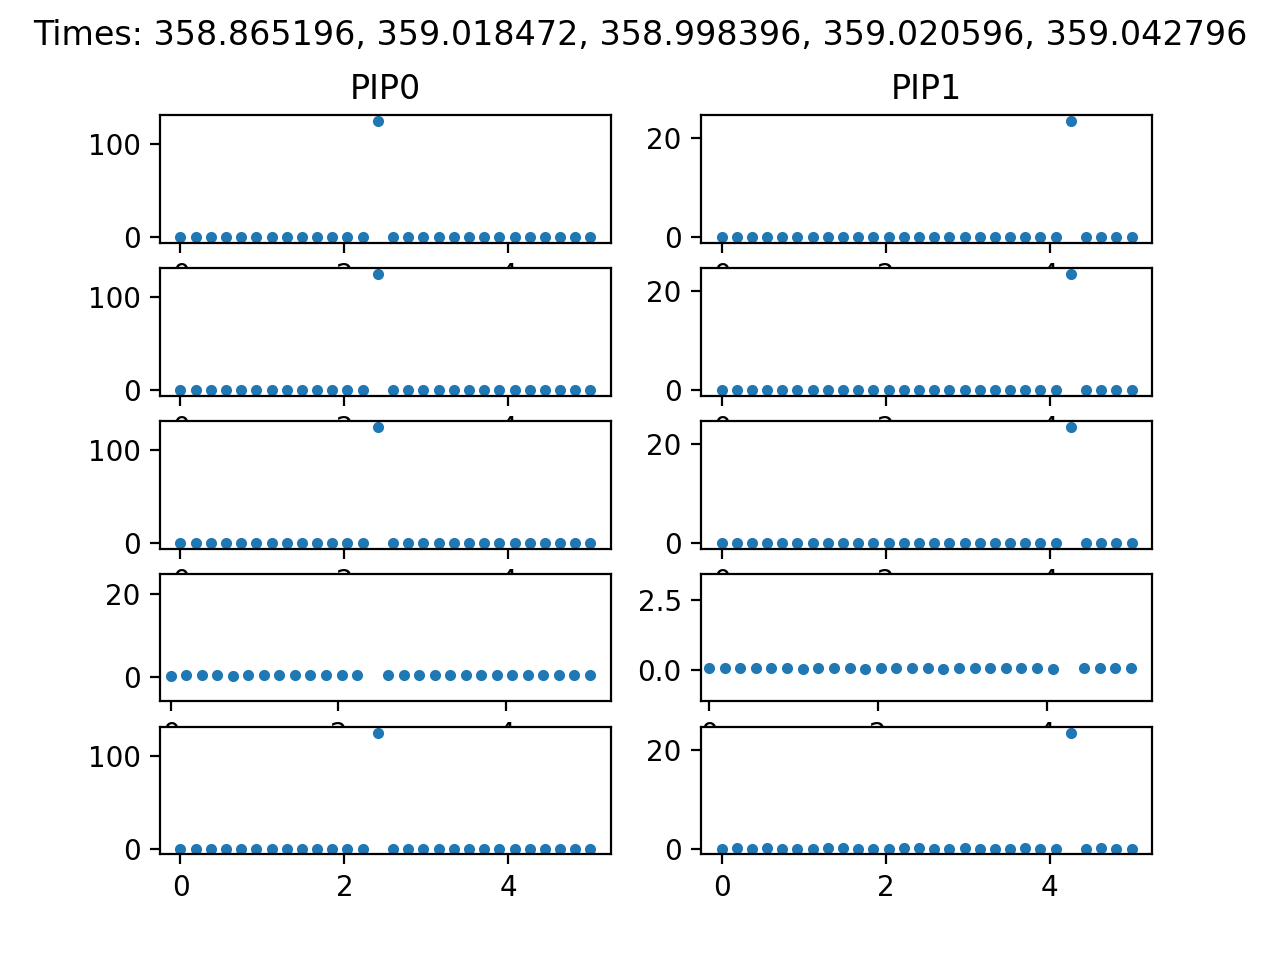

Text(0.5, 0.98, 'Times: 358.865196, 359.018472, 358.998396, 359.020596, 359.042796')

In [88]:
inx = 2167
fig2 = plt.figure(2) 
pip0Current = pip0Plot.copy()
pip1Current = pip1Plot.copy()
# for idx, plt_inx in zip([[1,2], [3,4], [5, 6]], np.arange(inx-1, inx+2, 1)): 
#     ax0 = fig2.add_subplot(3,2, idx[0])
#     ax1 = fig2.add_subplot(3,2, idx[1])
for idx, plt_inx in zip([[1,2], [3,4], [5, 6], [7,8], [9,10]], np.arange(inx-2, inx+3, 1)): 
    ax0 = fig2.add_subplot(5,2, idx[0])
    ax1 = fig2.add_subplot(5,2, idx[1])
    if idx[0]==1: ax0.set_title('PIP0'); ax1.set_title('PIP1')
    ax0.plot(sweep_voltage, np.flip(pip0Current[inx]), '.')
    ax1.plot(sweep_voltage, np.flip(pip1Current[inx]), '.')
# fig2.suptitle('Times: %s' % (', '.join([str(val) for val in sweepPlot[inx-1:inx+2]])))
fig2.suptitle('Times: %s' % (', '.join([str(val) for val in sweepPlot[inx-2:inx+3]])))

In [21]:
locs = np.where(np.logical_and(740<=sweepTime, sweepTime<=1385))[0]
locsrpt = np.where(np.logical_and(740<=sweepTimeRpt, sweepTimeRpt<=1385))[0]
print(sweepTime[locs])
print(sweepTimeRpt[locsrpt])
sweepTime_trim = sweepTime[locs]
sweepTimeRpt_trim = sweepTimeRpt[locsrpt]

[ 908.700908 1227.039524 1261.490221 ...  941.149     941.171204
  941.193396]
[1275.965724  740.017     740.039204 ...  931.114604  931.136796
  931.158996]


In [43]:
np.where(np.diff(sweepTime_trim)<0)[0]

(array([    0,  2144, 23117]),)

In [44]:
np.where(np.diff(sweepTimeRpt_trim)<0)[0]

array([    1,     7,  2227,  2254,  5596, 25541, 25992])

In [67]:
# np.delete(sweepTime_trim, [0, 2144, 23118]) 
inx = 2144
sweepTime_trim[inx-2:inx+3]
sweepTime_trim[0:5]

array([797.541372, 749.985236, 750.695128, 750.828328, 750.850532])

In [68]:
# [2, 8, 2227, 2255, 5596, 25542, 25993]
inx = 25992
sweepTimeRpt_trim[inx-2:inx+3]
sweepTimeRpt_trim[0:5]

array([740.638528, 740.838324, 740.731584, 741.015924, 741.104728])

In [95]:
sweepTimeRpt_trim[0:4]

array([740.638528, 740.838324, 740.731584, 741.015924])

In [63]:
np.isin(sweepTime_trim, sweepTimeRpt_trim)

array([False, False,  True, ..., False, False, False])

In [75]:
# np.delete(sweepTime_trim, [0, 2144, 23118]) 
# np.delete(sweepTime_trimRpt, [2, 8, 2227, 2255, 5596, 25542, 25993])


array([1.01593018, 1.02752686, 1.02172852, 1.02020264, 1.01348877,
       1.0055542 , 1.0055542 , 1.015625  , 1.02142334, 1.02020264,
       1.02630615, 1.01623535, 1.00738525, 1.01074219, 1.0067749 ,
       1.01501465, 1.02722168, 1.02355957, 1.02111816, 1.0168457 ,
       1.00616455, 1.00372314, 1.01348877, 1.01989746, 1.01928711,
       1.02722168, 1.01989746, 1.00982666])

<IPython.core.display.Javascript object>


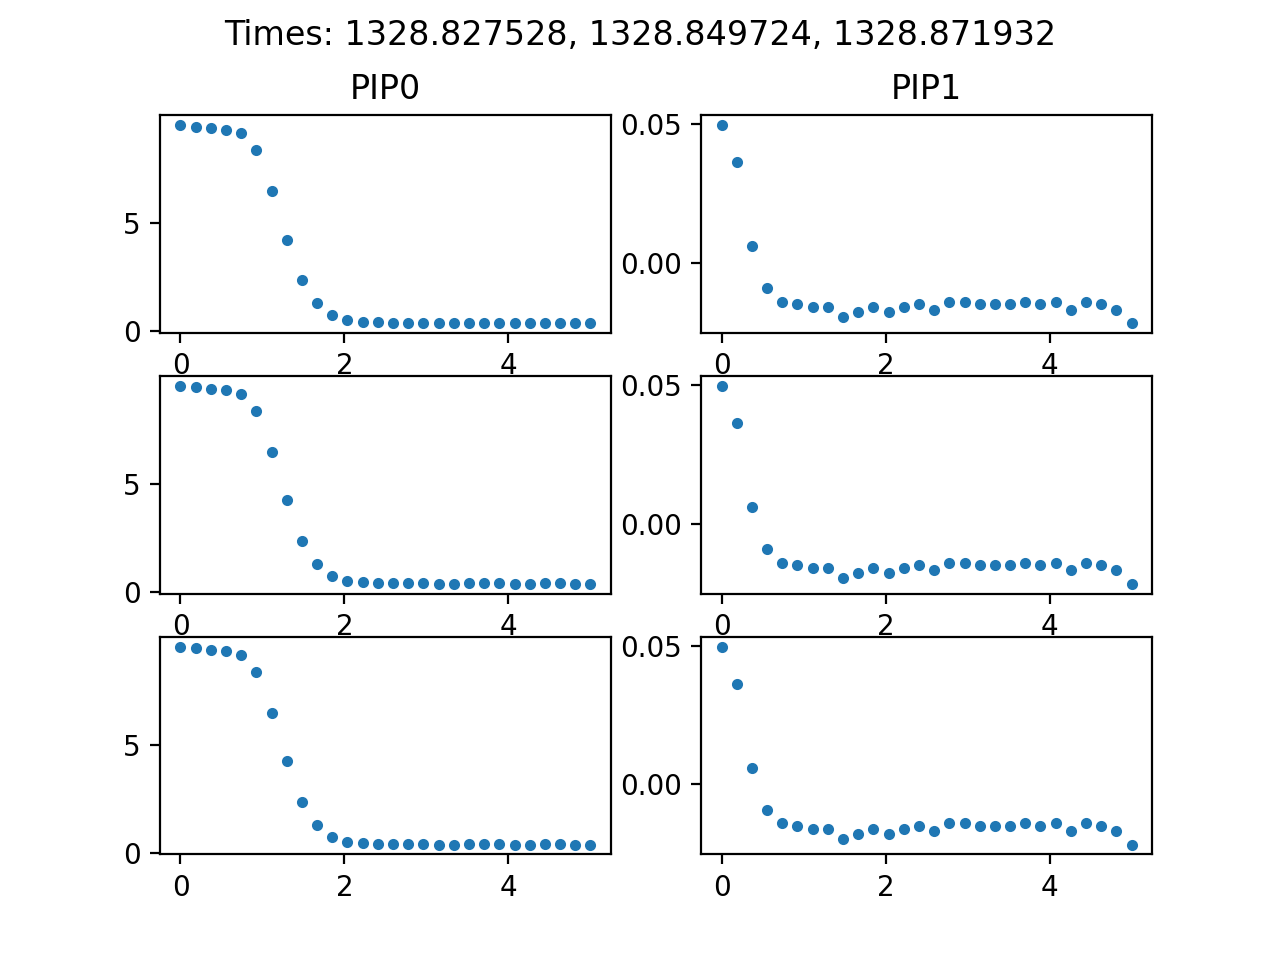

Text(0.5, 0.98, 'Times: 1328.827528, 1328.849724, 1328.871932')

In [106]:
inx = 26000
fig3 = plt.figure(3) 
pip0Current = pip0RptnA[locsrpt].copy()
pip1Current = pip1RptnA[locsrpt].copy()
for idx, plt_inx in zip([[1,2], [3,4], [5, 6]], np.arange(inx-1, inx+2, 1)): 
    ax0 = fig3.add_subplot(3,2, idx[0])
    ax1 = fig3.add_subplot(3,2, idx[1])
    if idx[0]==1: ax0.set_title('PIP0'); ax1.set_title('PIP1')
    ax0.plot(sweep_voltage, np.flip(pip0Current[inx]), '.')
    ax1.plot(sweep_voltage, np.flip(pip1Current[inx]), '.')
fig3.suptitle('Times: %s' % (', '.join([str(val) for val in sweepTimeRpt_trim[inx-1:inx+2]])))

In [107]:
sweep_voltage

array([0.        , 0.18518519, 0.37037037, 0.55555556, 0.74074074,
       0.92592593, 1.11111111, 1.2962963 , 1.48148148, 1.66666667,
       1.85185185, 2.03703704, 2.22222222, 2.40740741, 2.59259259,
       2.77777778, 2.96296296, 3.14814815, 3.33333333, 3.51851852,
       3.7037037 , 3.88888889, 4.07407407, 4.25925926, 4.44444444,
       4.62962963, 4.81481481, 5.        ])